In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import matplotlib.dates  as mdates

from datetime   import datetime, timezone
from legendmeta import LegendMetadata

lmeta = LegendMetadata('/Users/romoluque_c/Repositories/legend-metadata/')

In [3]:
run_dict = {'p03':{'r000':{},'r001':{},'r002':{},'r003':{},'r004':{},'r005':{}},
            'p04':{'r000':{},'r001':{},'r002':{},'r003':{}},
            'p06':{'r000':{},'r001':{},'r002':{},'r003':{},'r004':{},'r005':{}},
            'p07':{          'r001':{},'r002':{},'r003':{},'r004':{},'r005':{},'r006':{},'r007':{}}}
            #'p08':{          'r001':{},'r002':{},'r003':{},'r004':{},'r005':{},'r006':{}}}

In [4]:
data_path = '/Users/romoluque_c/LEGEND/Energy_scale_group/Partitioning/data_example/'
test_file = data_path + 'l200-p03-r000-cal-20230311T235840Z-par_pht.json'

In [5]:
dt    = datetime(2023, 4, 22, 5, 54, 22, tzinfo=timezone.utc)
chmap = lmeta.hardware.configuration.channelmaps.on(dt)
channel_dict = {}
for channel_name, channel_data in chmap.items():
    try:
        channel_dict[channel_data['daq']['rawid']] = (lmeta.channelmap(dt)[channel_name].type,
                                                      channel_name,
                                                      lmeta.channelmap(dt)[channel_name].production['mass_in_g'],
                                                      lmeta.channelmap(dt)[channel_name].location  ['string'],
                                                      lmeta.channelmap(dt)[channel_name].location  ['position'])
    except:
        continue

In [6]:
def cal_energy(e_uncal, cal_pars):
    if len(cal_pars.keys())==2:
        #print('lin')
        return cal_pars['a'] * e_uncal + cal_pars['b'], 'lin'
    elif len(cal_pars.keys())==3:
        #print('quad')
        return cal_pars['a'] * e_uncal **2 + cal_pars['b'] * e_uncal + cal_pars['c'], 'quad'

In [7]:
all_params_ch = {}

for sel_channel in ['ch1104000', 'ch1104001']:
    
    pars_per_ch = {'mus_peaks':        {}, 'mus_err_peaks':   {},
                   'fwhms_peaks':      {}, 'fwhms_err_peaks': {},
                   'ecals_peaks':      {},
                   'Qbb_fwhms_in_keV': [], 'Qbb_fwhms_err_in_keV': [],
                   'eres_lin_pars0':   [], 'eres_lin_pars0_err':   [],
                   'eres_lin_pars1':   [], 'eres_lin_pars1_err':   [],
                   'gains':            []}
    
    for i, period in enumerate(run_dict.keys()):
        for j, run in enumerate(run_dict[period].keys()):
            all_files = os.listdir(data_path)
            filename  = data_path + [f for f in all_files if f.startswith(f'l200-{period}-{run}')][0]
            with open (filename, 'r') as filehandler:
                results   = json.load(filehandler)
                res_chn   = results[sel_channel]['results']['ecal']
    
                ## Parameters for calibration
                cal_parameters = results[sel_channel]['pars']['operations']['cuspEmax_ctc_cal']['parameters']
                
                ## Parameters for resolution curve
                eres_lin_pars = res_chn['cuspEmax_ctc_cal']['eres_linear']

                pars_per_ch['Qbb_fwhms_in_keV']    .append({f'{period}-{run}': eres_lin_pars['Qbb_fwhm_in_keV']})
                pars_per_ch['Qbb_fwhms_err_in_keV'].append({f'{period}-{run}': eres_lin_pars['Qbb_fwhm_err_in_keV']})
                pars_per_ch['eres_lin_pars0']      .append({f'{period}-{run}': eres_lin_pars['parameters']   ['a']})
                pars_per_ch['eres_lin_pars0_err']  .append({f'{period}-{run}': eres_lin_pars['uncertainties']['a']})
                pars_per_ch['eres_lin_pars1']      .append({f'{period}-{run}': eres_lin_pars['parameters']   ['b']})
                pars_per_ch['eres_lin_pars1_err']  .append({f'{period}-{run}': eres_lin_pars['uncertainties']['b']})
                pars_per_ch['gains']               .append({f'{period}-{run}': cal_parameters['b']})
                            
                fitted_peaks   = res_chn['cuspEmax_ctc_cal']['fitted_peaks']
                peak_fits_pars = res_chn['cuspEmax_ctc_cal']['pk_fits']
                
                for peak in fitted_peaks:
                    if i==0 and j==0:
                        pars_per_ch['mus_peaks']      [peak] = {}
                        pars_per_ch['mus_err_peaks']  [peak] = {}
                        pars_per_ch['fwhms_peaks']    [peak] = {}
                        pars_per_ch['fwhms_err_peaks'][peak] = {}
                        pars_per_ch['ecals_peaks']    [peak] = {}
                        
                    pars_per_ch['mus_peaks']      [peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['parameters_in_ADC']   ['mu']
                    pars_per_ch['mus_err_peaks']  [peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['uncertainties_in_ADC']['mu']
                    pars_per_ch['fwhms_peaks']    [peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['fwhm_in_keV']         [0]   
                    pars_per_ch['fwhms_err_peaks'][peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['fwhm_in_keV']         [1]   
                    pars_per_ch['ecals_peaks']    [peak][f'{period}-{run}'] = cal_energy(peak_fits_pars[f'{peak}']['parameters_in_ADC']['mu'], cal_parameters)[0]

    all_params_ch[sel_channel] = pars_per_ch

In [8]:
all_params_ch;

In [9]:
for k1, v1 in all_params_ch.items():
    print(k1)
    for k2,v2 in all_params_ch[k1].items():
        print('         ', k2)
        try:
            for k3,v3 in all_params_ch[k1][k2].items():
                print('                ', k3)
                for k4,v4 in all_params_ch[k1][k2][k3].items():
                    print('                    ', k4)
        except:
            continue

ch1104000
          mus_peaks
                 583.191
                     p03-r000
                     p03-r001
                     p03-r002
                     p03-r003
                     p03-r004
                     p03-r005
                     p04-r000
                     p04-r001
                     p04-r002
                     p04-r003
                     p06-r000
                     p06-r001
                     p06-r002
                     p06-r003
                     p06-r004
                     p06-r005
                     p07-r001
                     p07-r002
                     p07-r003
                     p07-r004
                     p07-r005
                     p07-r006
                     p07-r007
                 727.33
                     p03-r000
                     p03-r001
                     p03-r002
                     p03-r003
                     p03-r004
                     p03-r005
                     p04-r000
                     

In [10]:
labels = [f'{key}-{run}' for key in run_dict.keys() for run in run_dict[key].keys()]

### Position of the different peaks:

In [11]:
all_fitted_peaks = np.array([583.191, 727.33, 860.564, 1592.53, 1620.5, 2103.53, 2614.5])

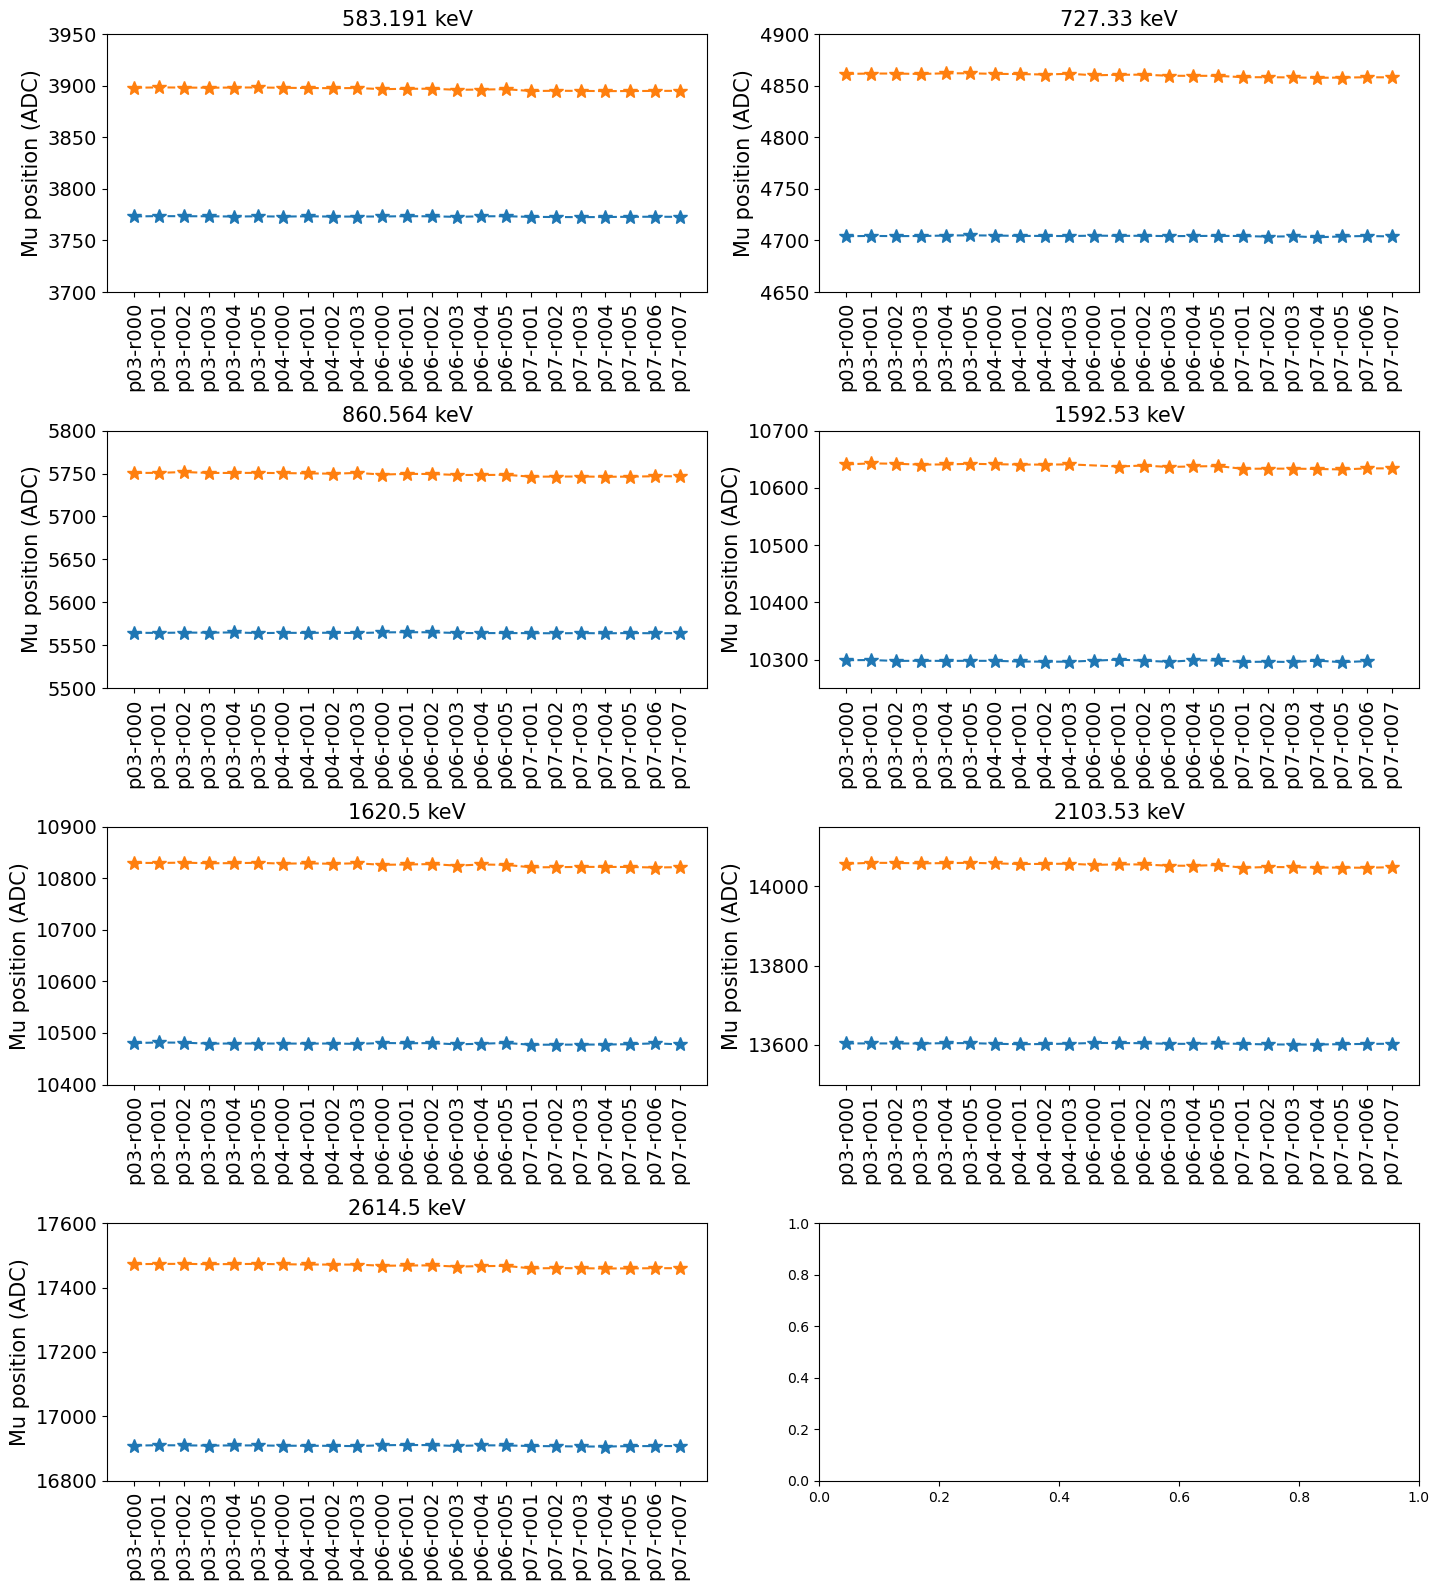

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(14.5, 16))
for i, (ax, peak, yl) in enumerate(zip(axs.flatten(), all_fitted_peaks, [( 3700,  3950),
                                                                         ( 4650,  4900),
                                                                         ( 5500,  5800),
                                                                         (10250, 10700),
                                                                         (10400, 10900),
                                                                         (13500, 14150),
                                                                         (16800, 17600)])):
    for channel in ['ch1104000', 'ch1104001']:
        ax.errorbar(list(all_params_ch[channel]['mus_peaks'][peak].keys()), 
                    list(all_params_ch[channel]['mus_peaks'][peak].values()),
                    yerr=list(all_params_ch[channel]['mus_err_peaks'][peak].values()),
                    marker='*', linestyle='--', markersize=10)
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(yl)
    ax.set_title(f'{peak} keV', fontsize=15)
    ax.set_ylabel('Mu position (ADC)', fontsize=15)
plt.tight_layout()
plt.show()

### FWHM for all peaks:

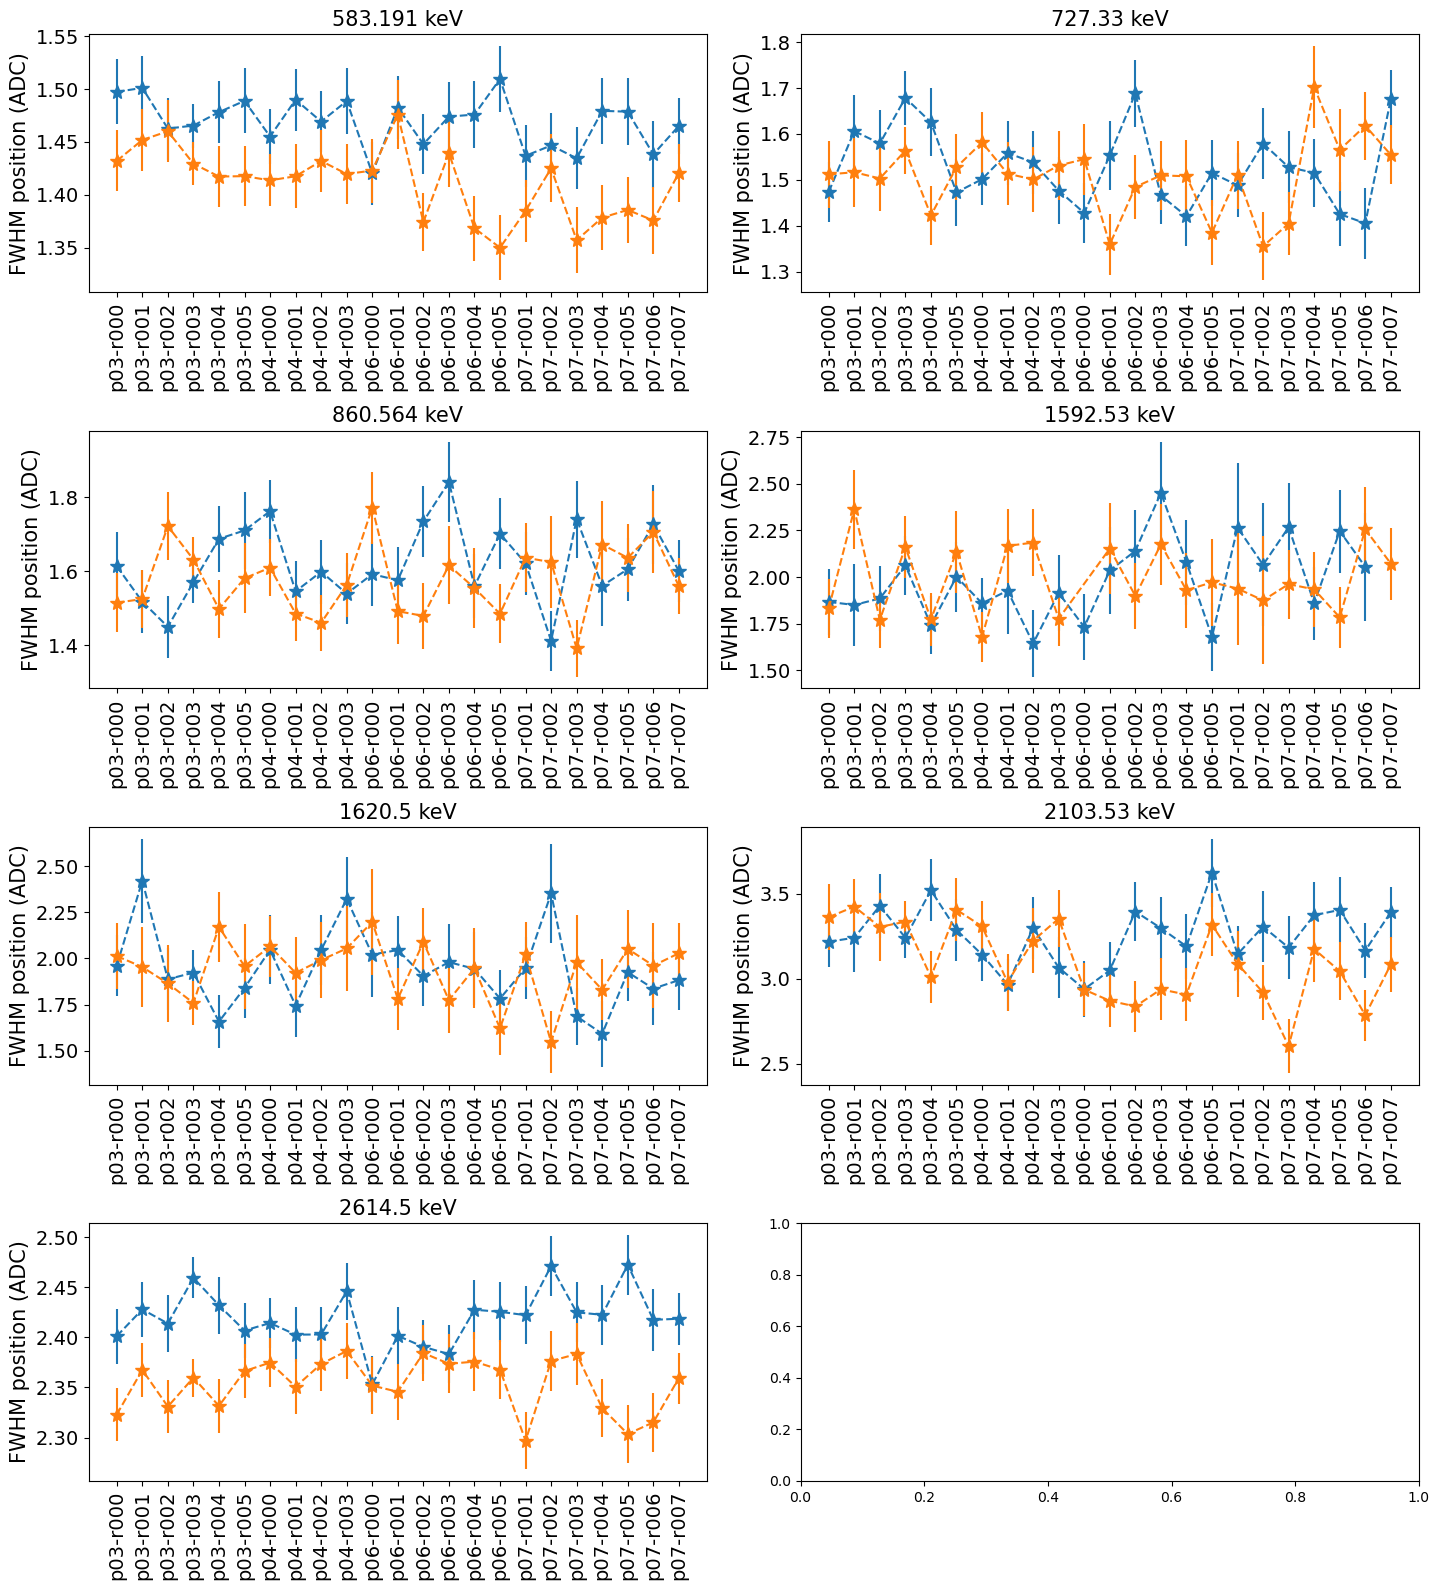

In [13]:
fig, axs = plt.subplots(4, 2, figsize=(14.5, 16))
for i, (ax, peak) in enumerate(zip(axs.flatten(), all_fitted_peaks)):
    for channel in ['ch1104000', 'ch1104001']:
        ax.errorbar(list(all_params_ch[channel]['fwhms_peaks'][peak].keys()), 
                    list(all_params_ch[channel]['fwhms_peaks'][peak].values()),
                    yerr=list(all_params_ch[channel]['fwhms_err_peaks'][peak].values()), 
                    marker='*', linestyle='--', markersize=10)
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(f'{peak} keV', fontsize=15)
    ax.set_ylabel('FWHM position (ADC)', fontsize=15)
plt.tight_layout()
plt.show()

### Residuals

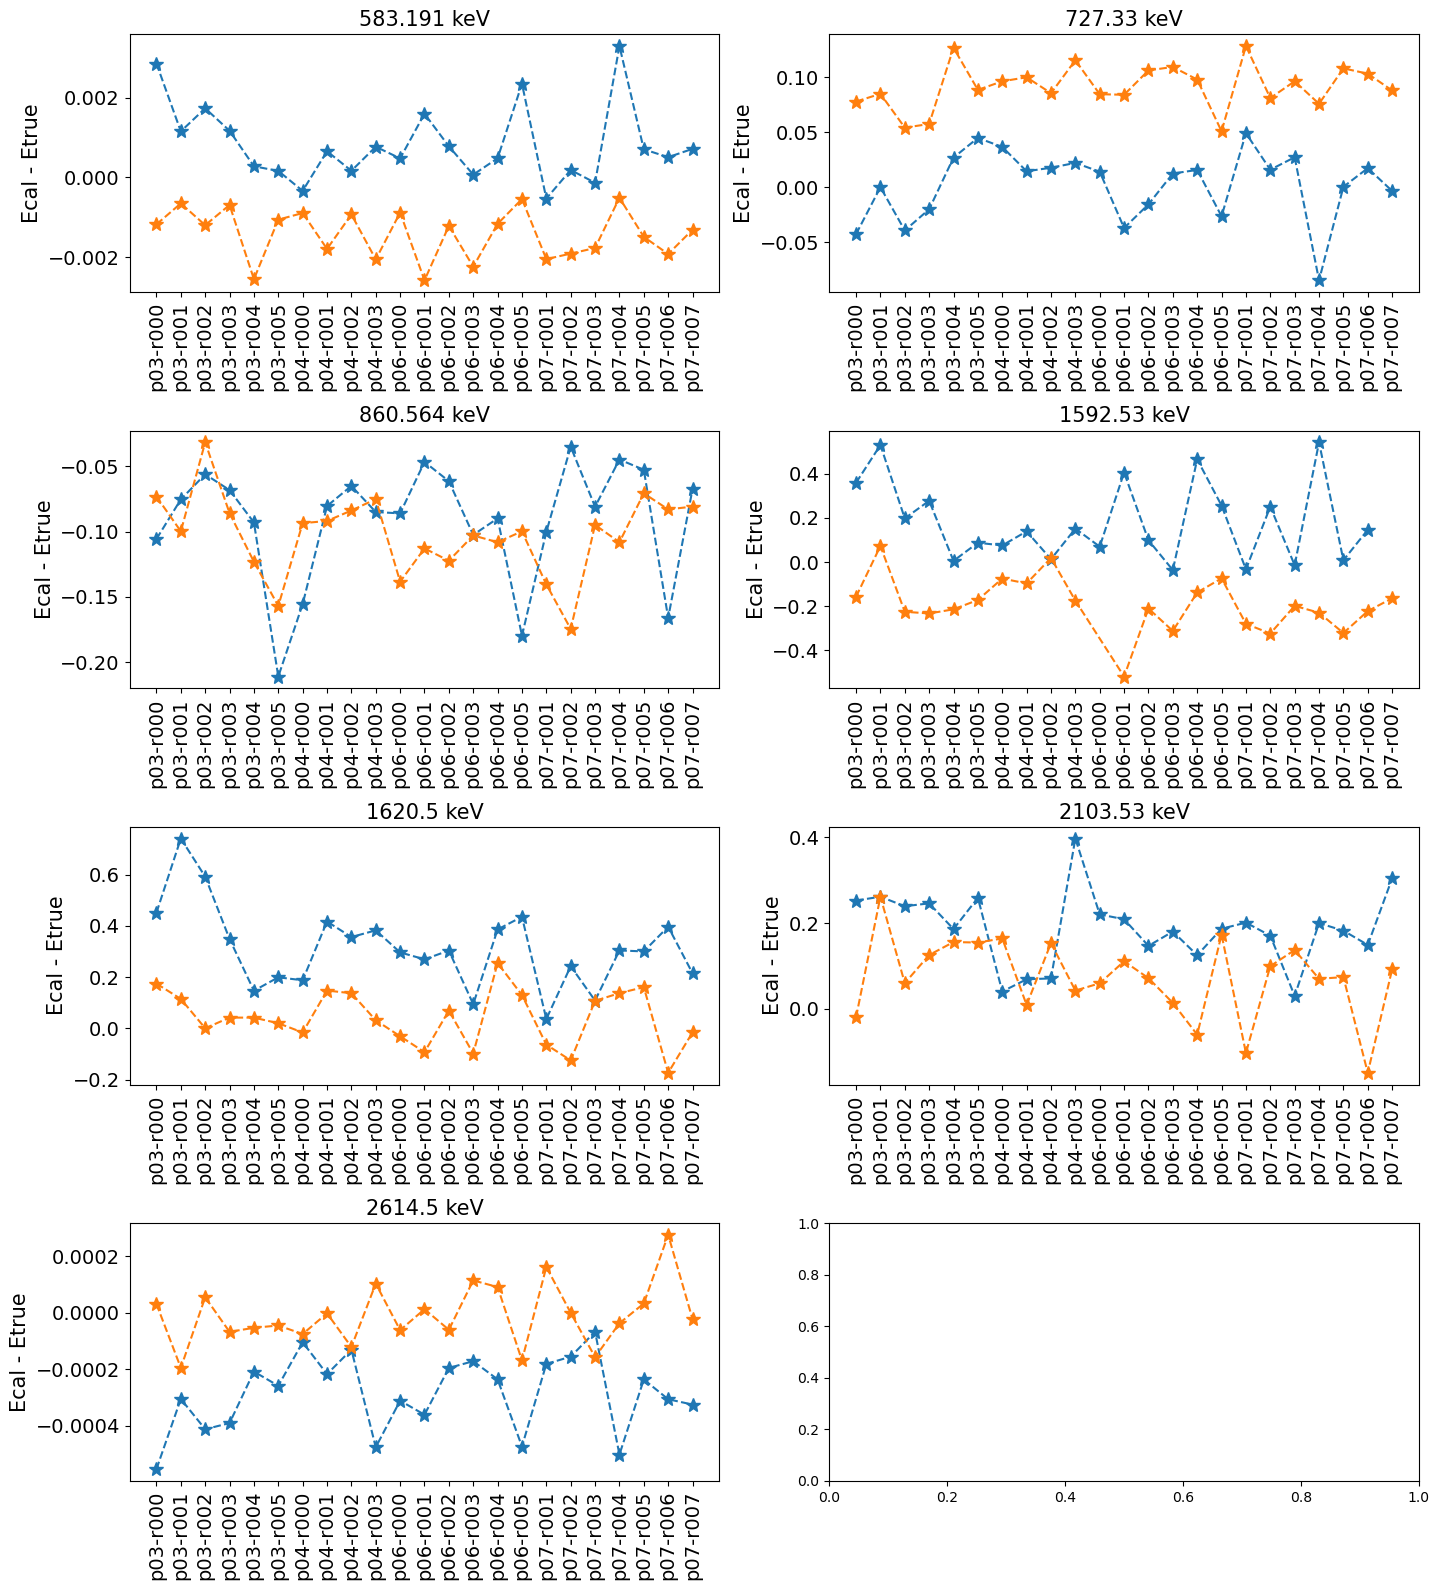

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(14.5, 16))
for i, (ax, peak) in enumerate(zip(axs.flatten(), all_fitted_peaks)):
    for channel in ['ch1104000', 'ch1104001']:
        ax.errorbar(list(all_params_ch[channel]['ecals_peaks'][peak].keys()), 
                    np.array(list(all_params_ch[channel]['ecals_peaks'][peak].values())) - peak,
                    marker='*', linestyle='--', markersize=10)
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(f'{peak} keV', fontsize=15)
    ax.set_ylabel('Ecal - Etrue', fontsize=15)
plt.tight_layout()
plt.show()

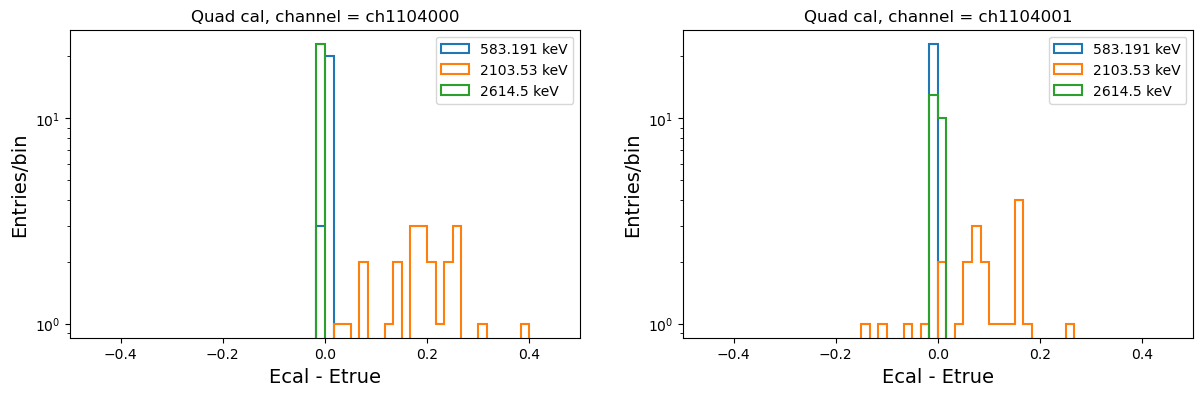

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(14.5, 4))
for channel, ax in zip(['ch1104000', 'ch1104001'], axs.flatten()):
    for i, peak in enumerate(all_fitted_peaks):
        if i in [0, 5, 6]:
            ax.hist(np.array(list(all_params_ch[channel]['ecals_peaks'][peak].values())) - peak, bins=60, range=(-0.5, 0.5), histtype='step', linewidth=1.5, label=f'{peak} keV')
    ax.set_xlabel('Ecal - Etrue', fontsize=14)
    ax.set_ylabel('Entries/bin',  fontsize=14)
    ax.set_title(f'Quad cal, channel = {channel}')
    ax.set_xlim(-0.5, 0.5)
    ax.legend()
    ax.set_yscale('log')
plt.show()

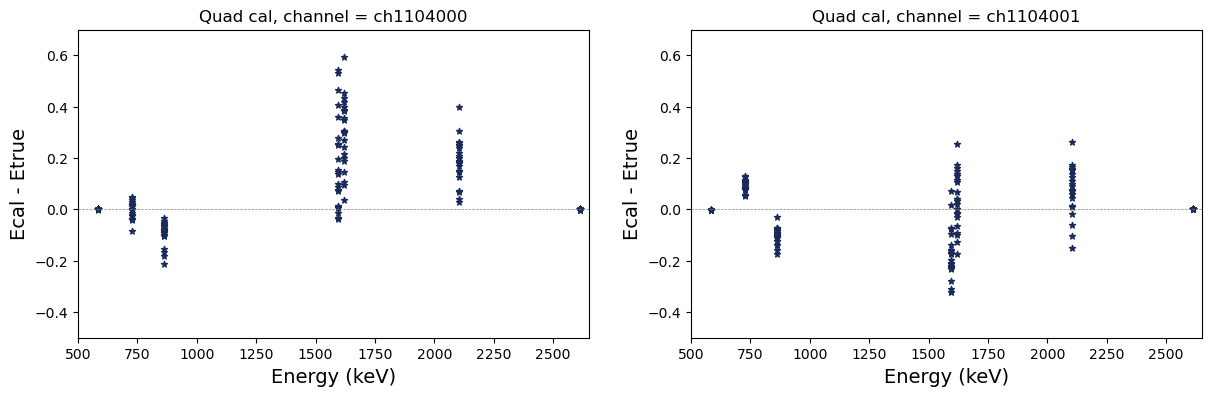

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14.5, 4))
for channel, ax in zip(['ch1104000', 'ch1104001'], axs.flatten()):
    ax.axhline(y=0, linestyle='--', linewidth=0.5, color='grey')
    for i, peak in enumerate(all_fitted_peaks):
        ax.scatter(np.full(len(all_params_ch[channel]['ecals_peaks'][peak].values()), peak), np.array(list(all_params_ch[channel]['ecals_peaks'][peak].values())) - peak, marker='*', s=20, color='#1A2A5B')
    ax.set_xlabel('Energy (keV)', fontsize=14)
    ax.set_ylabel('Ecal - Etrue', fontsize=14)
    ax.set_title(f'Quad cal, channel = {channel}')
    ax.set_xlim(500, 2650)
    ax.set_ylim(-0.5, 0.7)
plt.show()

### Gain

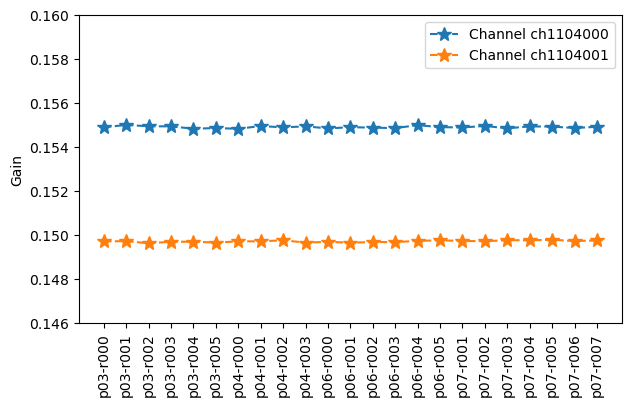

In [17]:
fig = plt.figure(figsize=(7, 4))
for channel in ['ch1104000', 'ch1104001']:
    plt.errorbar([list(i.keys  ())[0] for i in all_params_ch[channel]['gains']],
                 [list(i.values())[0] for i in all_params_ch[channel]['gains']],
                 marker='*', linestyle='--', markersize=10, label=f'Channel {channel}')
plt.ylabel('Gain')
plt.xticks(rotation=90)
plt.ylim(0.146, 0.16)
plt.legend()
plt.show()

### FWHM at Qbb

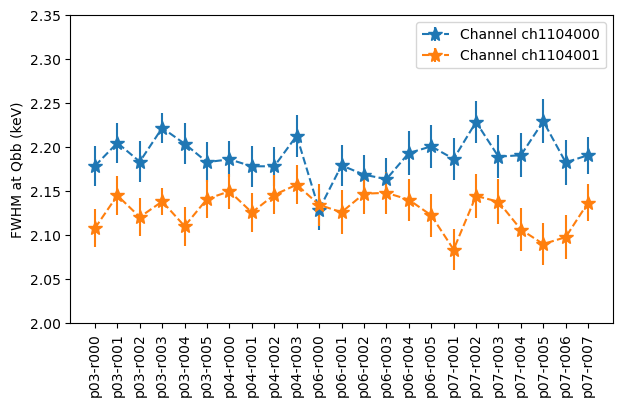

In [18]:
fig = plt.figure(figsize=(7, 4))
for channel in ['ch1104000', 'ch1104001']:
    plt.errorbar([list(i.keys  ())[0] for i in all_params_ch[channel]['Qbb_fwhms_in_keV']],
                 [list(i.values())[0] for i in all_params_ch[channel]['Qbb_fwhms_in_keV']],
                 yerr=[list(i.values())[0] for i in all_params_ch[channel]['Qbb_fwhms_err_in_keV']],
                 marker='*', linestyle='--', markersize=10, label=f'Channel {channel}')
plt.ylabel('FWHM at Qbb (keV)')
plt.xticks(rotation=90)
plt.ylim(2, 2.35)
plt.legend()
plt.show()

## Important parameters to plot:

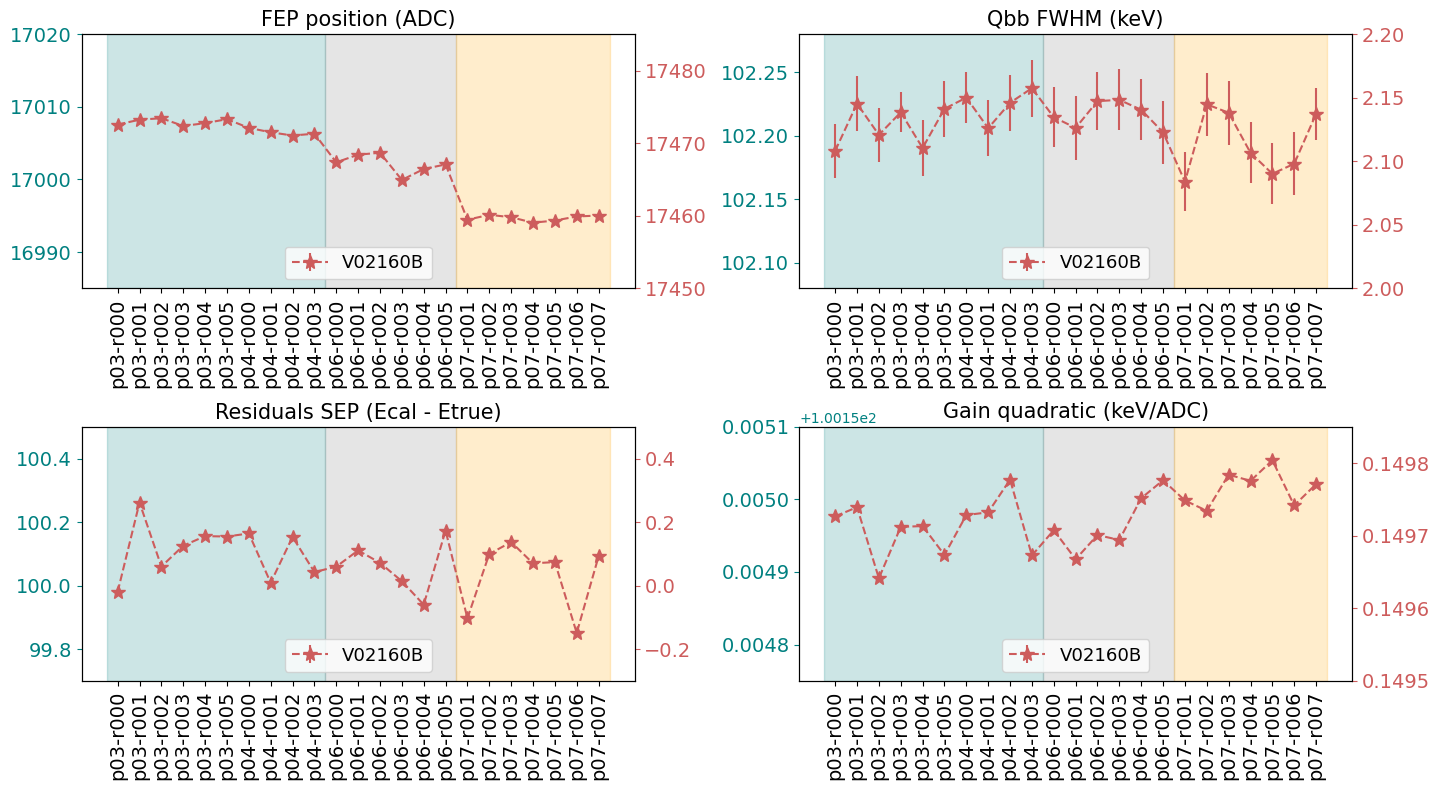

In [19]:
mus_FEP       = [list(all_params_ch[channel]['mus_peaks']    [2614.5].values())                     for channel in ['ch1104000', 'ch1104001']]
mus_err_FEP   = [list(all_params_ch[channel]['mus_err_peaks'][2614.5].values())                     for channel in ['ch1104000', 'ch1104001']]
mus_FEP_keys  = [list(all_params_ch[channel]['mus_peaks']    [2614.5].keys())                     for channel in ['ch1104000', 'ch1104001']]

qbb_fwhms      = [[list(i.values())[0] for i in all_params_ch[channel]['Qbb_fwhms_in_keV']]          for channel in ['ch1104000', 'ch1104001']]
qbb_fwhms_err  = [[list(i.values())[0] for i in all_params_ch[channel]['Qbb_fwhms_err_in_keV']]      for channel in ['ch1104000', 'ch1104001']]
qbb_fwhms_keys = [[list(i.keys())  [0] for i in all_params_ch[channel]['Qbb_fwhms_in_keV']]          for channel in ['ch1104000', 'ch1104001']]

residuals_SEP = [np.array(list(all_params_ch[channel]['ecals_peaks'][2103.53].values())) - 2103.53 for channel in ['ch1104000', 'ch1104001']]
residuals_SEP_keys = [list(all_params_ch[channel]['ecals_peaks'][2103.53].keys())                  for channel in ['ch1104000', 'ch1104001']]
gains         = [[list(i.values())[0] for i in all_params_ch[channel]['gains']]                     for channel in ['ch1104000', 'ch1104001']]
gains_keys    = [[list(i.keys())  [0] for i in all_params_ch[channel]['gains']]                     for channel in ['ch1104000', 'ch1104001']]

params   = [mus_FEP, qbb_fwhms, residuals_SEP, gains]
errs     = [mus_err_FEP, qbb_fwhms_err,
            [np.full(len(residuals_SEP[0]), 0.0001),   np.full(len(residuals_SEP[1]), 0.0001)],
            [np.full(len(gains[0]),         0.000001), np.full(len(gains[1]),         0.000001)]]
all_keys = [mus_FEP_keys, qbb_fwhms_keys, residuals_SEP_keys, gains_keys]
            
ylabels   = ['FEP position (ADC)', 'Qbb FWHM (keV)', 'Residuals SEP (Ecal - Etrue)', 'Gain quadratic (keV/ADC)']
ylims     = [(16885, 16920), (2.08, 2.28), (-0.3, 0.5), (0.15475, 0.15510)]
ylims2    = [(17450, 17485), (2.00, 2.20), (-0.3, 0.5), (0.14950, 0.14985)]

det_names = [channel_dict[int(channel[2:])][1] for channel in ['ch1104000', 'ch1104001']]

data  = list(all_params_ch[channel]['ecals_peaks'][peak].keys())
ivals = [next((i for i, item in enumerate(data)  if item.startswith(p)), None) for p in ['p03', 'p06', 'p07']] + [len(data)]

fig, axs = plt.subplots(2, 2, figsize=(14.5, 8))
for i, (ax, pars, errs, keys, ylim, ylim2, ylab) in enumerate(zip(axs.flatten(), params, errs, all_keys, ylims, ylims2, ylabels)):
    ax.errorbar(keys[0], pars[0], yerr=errs[0], marker='*', linestyle='--', markersize=10, color='teal', label=det_names[0])
    ax2 = ax.twinx()
    ax2.errorbar(keys[1], pars[1], yerr=errs[1], marker='*', linestyle='--', markersize=10, color='indianred', label=det_names[1])
    ax.tick_params( axis='x', labelsize=14, rotation=90)
    ax.tick_params( axis='y', labelsize=14, colors='teal')
    ax2.tick_params(axis='y', labelsize=14, colors='indianred')
    ax.set_title(f'{ylab}', fontsize=15)
    ax.set_ylim(ylim[0]+100, ylim[1]+100)
    ax2.set_ylim(ylim2)
    #ax. legend(loc='lower left',   fontsize=13)
    ax2.legend(loc='lower center', fontsize=13)
    
    for i, (col) in enumerate(['teal', 'grey', 'orange']):
        ax.axvspan(ivals[i] - 0.5, ivals[i+1] - 0.5, alpha=0.2, color=col)

plt.tight_layout()
plt.show()

## Partitions

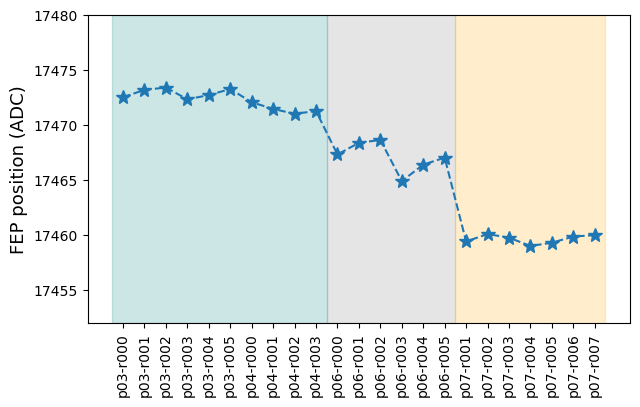

In [20]:
fig = plt.figure(figsize=(7, 4))
channel = 'ch1104001'
peak    = 2614.5
plt.errorbar(list(all_params_ch[channel]['ecals_peaks'][peak].keys()),
             list(all_params_ch[channel]['mus_peaks'][peak].values()),
             yerr=list(all_params_ch[channel]['mus_err_peaks'][peak].values()),
             marker='*', linestyle='--', markersize=10)
plt.ylim(17452, 17480)
plt.ylabel('FEP position (ADC)', fontsize=13)

data  = list(all_params_ch[channel]['ecals_peaks'][peak].keys())
ivals = [next((i for i, item in enumerate(data)  if item.startswith(p)), None) for p in ['p03', 'p06', 'p07']] + [len(data)]

for i, (col) in enumerate(['teal', 'grey', 'orange']):
    plt.axvspan(ivals[i] - 0.5, ivals[i+1] - 0.5, alpha=0.2, color=col)
    
plt.xticks(rotation=90)
plt.show()